# Property Clustring

In [1]:
# libraries
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Structured Data Exploration

In [2]:
#Step 1 — Load only what is needed
use_cols = [
    "PropertyID",
    "Currentavmvalue",
    "equityValue",
    "EquityPercent",
    "LOO",
    "Age",
    "FinalOwnerType",
    "Beds",
    "FullBaths",
    "HalfBaths",
    "Sqft",
    "building_condition",
    "owneroccupied",
    "multi_owner",
    "Lien",
    "TCounty",
    "TState"
]

df_combined = pd.read_csv(os.path.join("data", "combined_output.csv"),
    usecols=use_cols,
    low_memory=False
)

# print df shape
print("df_combined shape: ", df_combined.shape)

df_combined shape:  (5300825, 17)


In [3]:
df_combined['TState'].value_counts()

TState
MD    2304748
VA    1980783
PA     423441
FL     152992
DC     149258
CT     133302
MA     101957
TN      54058
Va        224
Md         38
Pa         22
Ma          1
Ct          1
Name: count, dtype: int64

### check/handle missing data

In [4]:
# check for missing values in percentage
for col in df_combined.columns:
    print(col, round(df_combined[col].isna().sum() / len(df_combined) * 100,2), "%")


PropertyID 0.0 %
Currentavmvalue 0.0 %
equityValue 0.0 %
EquityPercent 0.0 %
TCounty 0.0 %
TState 0.0 %
FinalOwnerType 0.0 %
owneroccupied 67.96 %
building_condition 99.7 %
multi_owner 67.96 %
Lien 99.84 %
LOO 22.93 %
Beds 83.45 %
FullBaths 69.95 %
HalfBaths 84.36 %
Sqft 69.29 %
Age 0.88 %


In [5]:
# Structurally reliable features (near-complete)
tier1_col = [
   'Currentavmvalue',
   'equityValue',
   'EquityPercent',
   'FinalOwnerType',
   'Age',
   'LOO' 
]

In [6]:
# Step 2.1 — Encode informative missingness
df_combined["LOO_missing"] = df_combined["LOO"].isna().astype(int)
df_combined["Age_missing"] = df_combined["Age"].isna().astype(int)


In [7]:
# step 2.2 log transformation of LOO:
# because Early tenure differences matter a lot, but Very long tenure differences matter less, so keeping LOO linear, means: “90 → 100 years is as important as 20 → 30 years.” 
# Which is almost certainly false behaviorally.

df_combined["LOO_log"] = np.log1p(df_combined["LOO"])


In [8]:
# Step 2.3 - Encode Categorical features
df_combined['is_AO'] = (df_combined['FinalOwnerType'] == 'AO').astype(int)
#df_combined['is_OO'] = df_combined['FinalOwnerType'] == 'OO'  # redundant, as is_AO = 1 - is_OO

In [9]:
#Step 3.1 — AVM bins (binned current market valuation of the property) --> to be used at sampleing stage not clustering
df_combined["AVM_bin"] = pd.qcut(  # creates Equal-width bins
    df_combined["Currentavmvalue"],
    q=10,
    duplicates="drop"
)

#step 3.2 - log transformation
df_combined["Currentavmvalue_log"] = np.log1p(df_combined["Currentavmvalue"])

#### # Age: Cap at 100 years
##### “Age matters… until it doesn’t.”

stop pretending we can distinguish degrees of ‘very old’ in a meaningful way”

Without capping:
- Age = 300 can dominate distance vs Age = 80
- Even though both are “old” from an investor perspective
- And even though other variables (equity, tenure) already encode the real signal

In [10]:
# Age: Cap at 100 years
df_combined["is_very_old"] = (df_combined["Age"] > 100).astype(int)  # a secondary binary feature

df_combined["Age_capped"] = df_combined["Age"].clip(upper=100)


<Axes: ylabel='Frequency'>

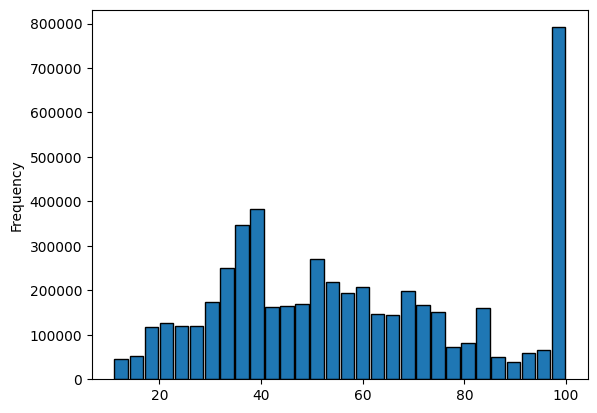

In [11]:
df_combined["Age_capped"].plot.hist(bins=30, edgecolor="black", rwidth=0.9)

In [12]:
#Step 4 - Data cleaning
# 1.drop rows with EquityPercent >100%
df_combined = df_combined[df_combined["EquityPercent"] <= 100]

# EquityPercent == 100 must be treated as a state (is_fully_paid)
df_combined["is_fully_paid"] = (df_combined["EquityPercent"] == 100).astype(int)

# create continuous part of 'EquityPercent'
df_combined["EquityPercent_cont"] = df_combined["EquityPercent"].where(
    df_combined["EquityPercent"] < 100
)


###  Stratified sampling

In [13]:
# Step 4 — Stratified sampling
target_size = 150_000
sample_frac = target_size / len(df_combined)

strata_cols = [
    #"FinalOwnerType",
    "AVM_bin",
    "LOO_missing", # to get same fraction of missingness in the sample
    "Age_missing"
]


#--
#- Large strata contribute many rows
#- Small but important strata are preserved
#- Rare combinations don’t disappear
#--
sampled_df = (
    df_combined
    .groupby(strata_cols, group_keys=False, observed=False)
    .apply(lambda x: x.sample(
        frac=sample_frac,
        random_state=42
    ))
)

# step 5 — Save
sampled_df.to_csv(os.path.join("data",
    "combined_output_stratified_sample.csv"),
    index=False
)

C:\Users\Home\AppData\Local\Temp\ipykernel_15080\2892230064.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(


NOTE: this sample is a faithful representation of the core investor-targetable population

In [14]:
sampled_df.shape

(150001, 27)

In [15]:
sampled_df["FinalOwnerType"].value_counts(normalize=True)

FinalOwnerType
AO    0.52145
OO    0.47855
Name: proportion, dtype: float64

In [16]:
df_combined["FinalOwnerType"].value_counts(normalize=True)

FinalOwnerType
AO    0.520437
OO    0.479563
Name: proportion, dtype: float64

In [17]:
# Is Missingness preserved? (this is critical)
sampled_df[["LOO_missing", "Age_missing"]].mean()


LOO_missing    0.229292
Age_missing    0.008840
dtype: float64

In [18]:
df_combined[["LOO_missing", "Age_missing"]].mean()

LOO_missing    0.229285
Age_missing    0.008838
dtype: float64

In [19]:
# AVM distribution sanity
sampled_df["Currentavmvalue"].describe()

count    1.500010e+05
mean     3.619314e+05
std      1.709245e+05
min      4.000000e+04
25%      2.394180e+05
50%      3.300000e+05
75%      4.460000e+05
max      2.046517e+06
Name: Currentavmvalue, dtype: float64

In [20]:
df_combined['Currentavmvalue'].describe()

count    5.300800e+06
mean     3.617401e+05
std      1.705190e+05
min      4.000000e+04
25%      2.396440e+05
50%      3.300000e+05
75%      4.455102e+05
max      2.172704e+06
Name: Currentavmvalue, dtype: float64

Note:

the max in the sample vs original df shows discrapency.

Are properties above $1.1M strategically meaningful for investor conversion?

- If no → proceed as-is. The sample is fine. (Going with this option for now)

- If yes → keep top 0.1% by AVM (sample separately) and sample the rest and then combine 

### Investigation

In [21]:
sampled_df['FinalOwnerType'].value_counts(normalize=True, dropna=False)

FinalOwnerType
AO    0.52145
OO    0.47855
Name: proportion, dtype: float64

==> 'FinalOwnerType' is dangerous and valuable. should not let FinalOwnerType directly drive distance in the first clustering pass. Should be excluded from distance metric to avoid trivial soltion:
“Cluster 1 = AO, Cluster 2 = OO”

In [22]:
sampled_df.groupby("FinalOwnerType")[
    ["EquityPercent", "LOO_missing"]
].mean()

,EquityPercent,LOO_missing
FinalOwnerType,,
AO,84.367946,0.221650
OO,74.976164,0.237619


Conclusion:
- Missing LOO is not explained by ownership type
- AO tend to be further along the financial lifecycle/ But many OO are also high-equity/ And many AO are still leveraged

so 'FinalOwnerType' should inform ranking, not geometry. It carries secondary interpretation.

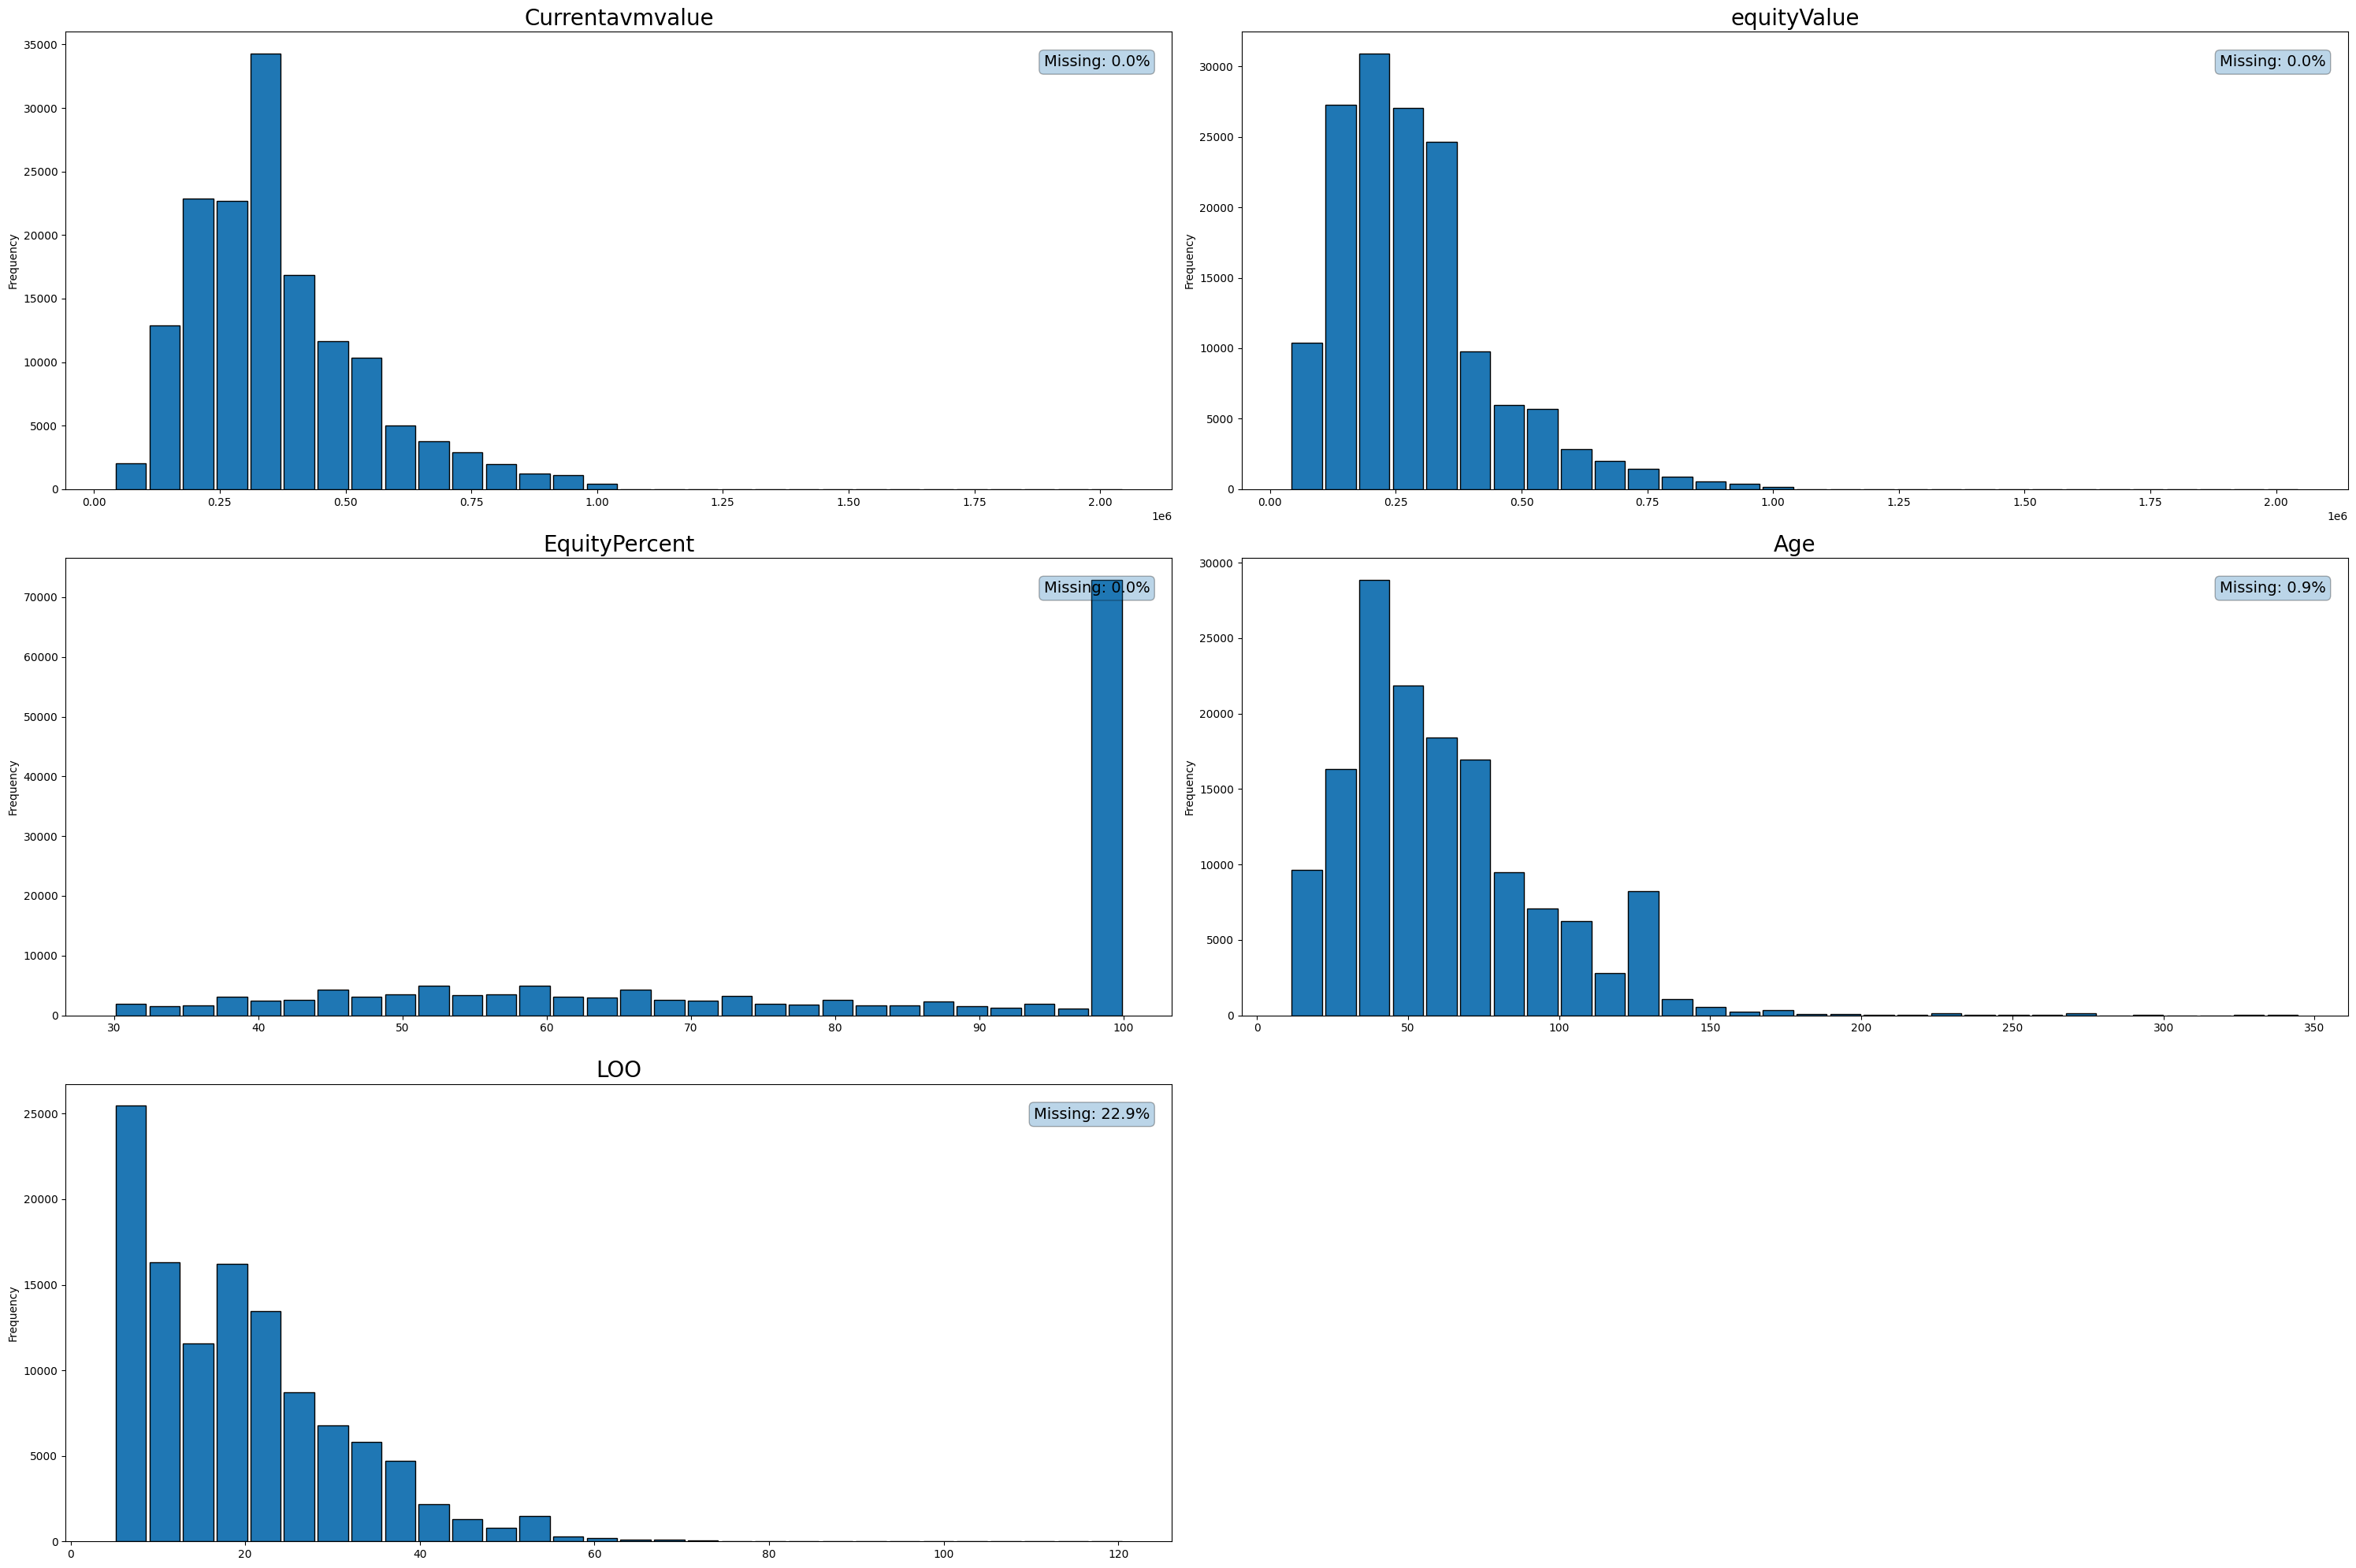

In [23]:
# make a 2 by 2 plot
plt.figure(figsize=(30, 20))
# tier1_col exclufing final owner type
col = [c for c in tier1_col if c != "FinalOwnerType"]

for i, col in enumerate(col):
    ax = plt.subplot(3, 2, i + 1)
    ax.set_title(col,fontsize=20)
    sampled_df[col].plot.hist(bins=30, edgecolor="black", rwidth=0.9)

    missing_pct = sampled_df[col].isna().mean() * 100

    ax.text(
        0.98, 0.95,
        f"Missing: {missing_pct:.1f}%",
        transform=ax.transAxes,
        ha="right",
        va="top",
        fontsize=14,
        bbox=dict(boxstyle="round,pad=0.3", alpha=0.3)
    )
    
    plt.tight_layout()

### Observation:

### 1. EquityPercent = 100 is a proxy for ownership psychology, not just finance.

From a behavioral standpoint, these owners are different:

- Often long LOO
- Often older properties
- Frequently absentee owners
- Emotionally detached from the property
- Much easier investor conversations

==> EquityPercent == 100, is_fully_paid? or EquityPercent_capped?

In [24]:
# How many are fully paid?
(sampled_df['is_fully_paid']).mean()

0.481176792154719

In [25]:
# Relationship with LOO
sampled_df.groupby(sampled_df['is_fully_paid'])["LOO"].describe()

,count,mean,std,min,25%,50%,75%,max
is_fully_paid,,,,,,,,
0,67382.0,16.928916,9.913877,4.982888,8.629706,15.583847,22.102669,80.027379
1,48225.0,22.708482,12.867009,4.988364,11.463381,21.177276,31.589322,120.596851


Text(0.3, 0.3, 'Mean: 22.7')

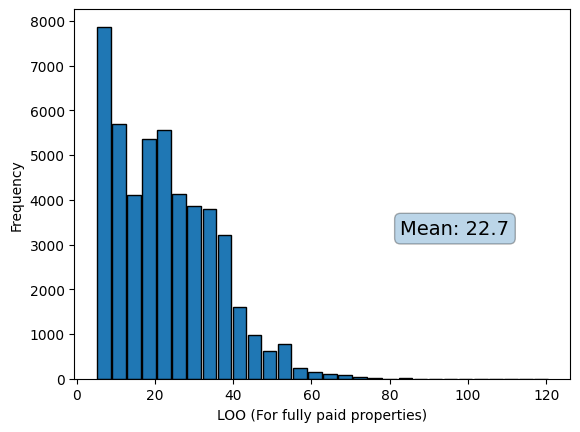

In [26]:
# plot LOO histogram for fully paid

sampled_df[sampled_df['is_fully_paid']==1]["LOO"].plot.hist(bins=30, edgecolor="black", rwidth=0.9)

# set labels
plt.xlabel("LOO (For fully paid properties)")
plt.ylabel("Frequency")

meanLoo = round(sampled_df[sampled_df['is_fully_paid']==1]["LOO"].mean(),1)
# print the mean value
#plt.text(100, 5000, f'mean LOO:{meanLoo}')
plt.text(
        0.3, 0.3,
        f"Mean: {meanLoo:.1f}",
        transform=ax.transAxes,
        ha="right",
        va="top",
        fontsize=14,
        bbox=dict(boxstyle="round,pad=0.3", alpha=0.3))

In [27]:
sampled_df.head(5)

,PropertyID,Currentavmvalue,equityValue,EquityPercent,TCounty,TState,FinalOwnerType,owneroccupied,building_condition,multi_owner,Lien,LOO,Beds,FullBaths,HalfBaths,Sqft,Age,LOO_missing,Age_missing,LOO_log,is_AO,AVM_bin,Currentavmvalue_log,is_very_old,Age_capped,is_fully_paid,EquityPercent_cont
5067265,62191438,99000.0,99000,100,Allegany County,MD,AO,0.0,NaN,1.0,NaN,34.116359,NaN,1.0,NaN,744.0,77.0,0,0,3.558667,1,"(39999.999, 174000.0]",11.502885,0,77.0,1,NaN
2097214,62707548,172000.0,172000,100,Baltimore,MD,OO,NaN,NaN,NaN,NaN,50.773443,NaN,NaN,NaN,NaN,82.0,0,0,3.946877,0,"(39999.999, 174000.0]",12.055256,0,82.0,1,NaN
2819727,64478076,132000.0,132000,100,Baltimore city,MD,AO,NaN,NaN,NaN,NaN,6.253251,NaN,NaN,NaN,NaN,94.0,0,0,1.981450,1,"(39999.999, 174000.0]",11.790565,0,94.0,1,NaN
4411295,64621859,80000.0,80000,100,Baltimore city,MD,AO,0.0,NaN,1.0,NaN,7.928816,NaN,1.0,NaN,960.0,71.0,0,0,2.189284,1,"(39999.999, 174000.0]",11.289794,0,71.0,1,NaN
2109695,64326849,147000.0,147000,100,Wicomico,MD,AO,NaN,NaN,NaN,NaN,43.022587,NaN,NaN,NaN,NaN,100.0,0,0,3.784703,1,"(39999.999, 174000.0]",11.898195,0,100.0,1,NaN


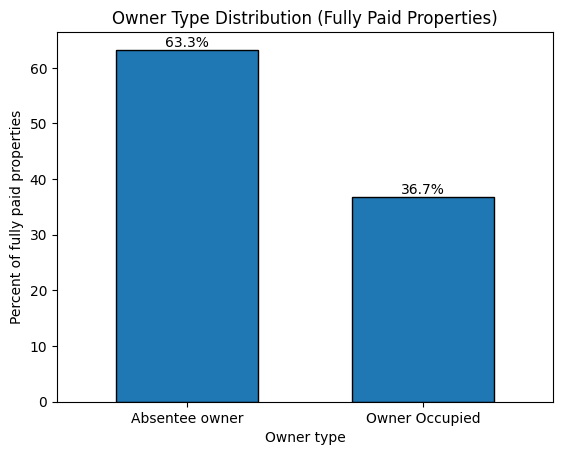

In [28]:
# plot AO histograms for fully paid

ownership_pct = sampled_df[sampled_df["is_fully_paid"] == 1]["is_AO"].value_counts(normalize=True) * 100


ax = ownership_pct.rename({1: "Absentee owner", 0: "Owner Occupied"}).plot.bar(
    edgecolor="black",
    width=0.6
)

ax.set_ylabel("Percent of fully paid properties")
ax.set_xlabel("Owner type")
ax.set_title("Owner Type Distribution (Fully Paid Properties)")

# annotate bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f"{height:.1f}%",
        (p.get_x() + p.get_width() / 2, height),
        ha="center",
        va="bottom"
    )
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.show()


==> Conclusion: 
- Fully paid ownership and absentee ownership are correlated, but not redundan
- Baseline rate of AO is 52%
- Being fully paid increases the likelihood of being absentee
- is_AO is a good secondary explanatory variable
    - If you had let is_AO into the distance metric --> Clusters would lean heavily toward AO/OO separation

In investor terms, fully paid owners are:
- More likely to be absentee (63.3%)
- More likely to sell directly
- Less constrained by lenders
- But one in three fully paid owners still live in the home (36.7%)

### Missing LOO is not “unknown” — it’s a proxy state

In [29]:
df_missing_loo = sampled_df[sampled_df["LOO_missing"]==1]
df_non_missing_loo = sampled_df[sampled_df["LOO_missing"]==0]

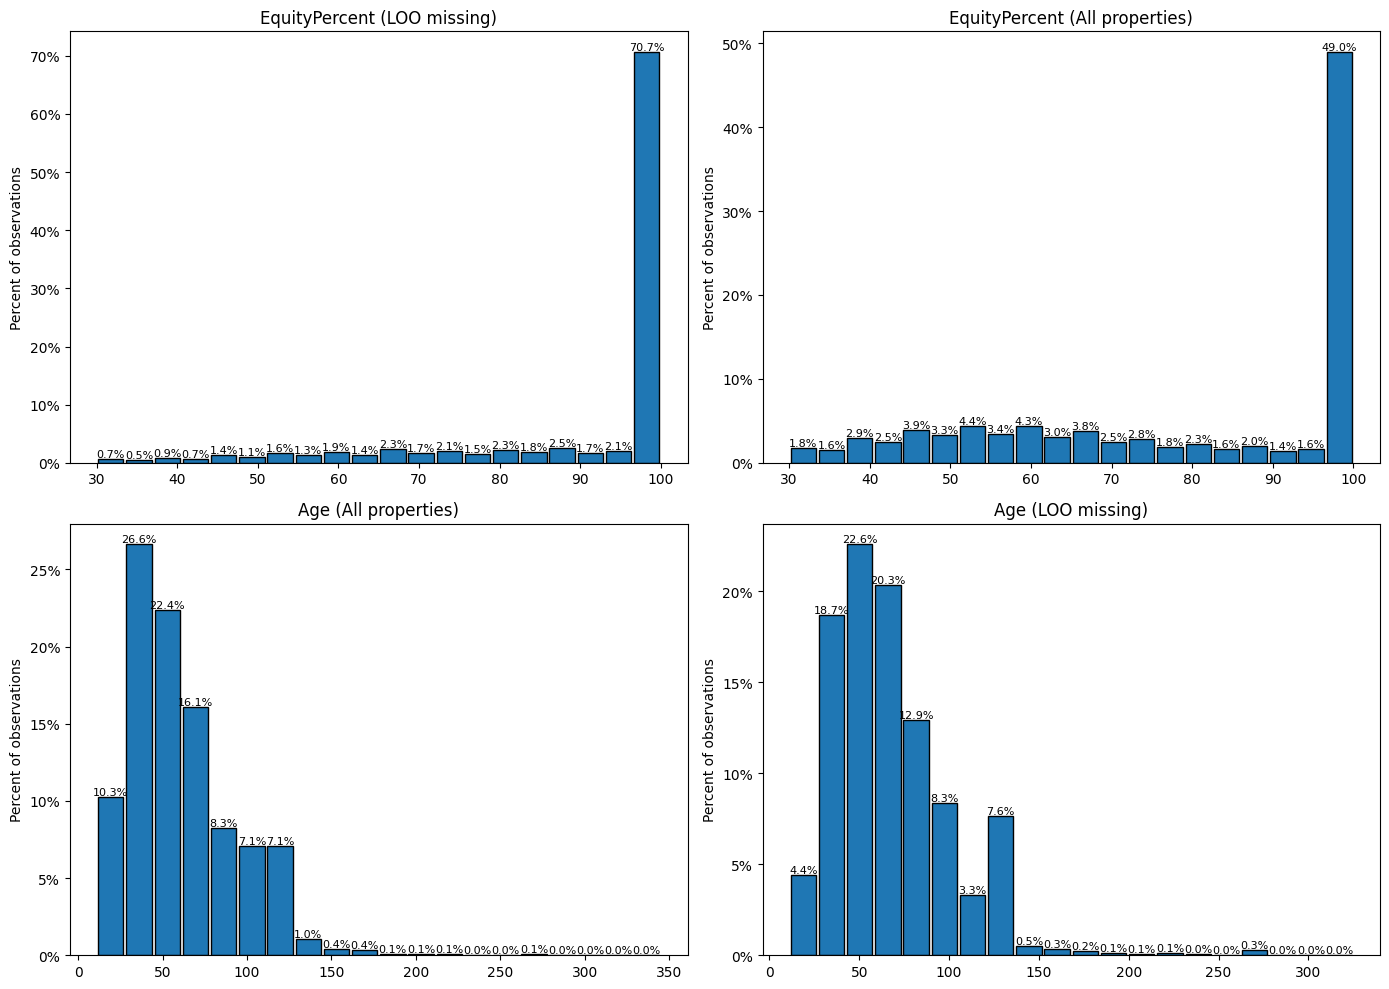

In [30]:
def percent_hist(ax, data, bins, xlabel, title):
    weights = np.ones(len(data)) / len(data) * 100

    ax.hist(
        data,
        bins=bins,
        weights=weights,
        edgecolor="black",
        rwidth=0.9
    )

    #ax.set_xlabel(xlabel)
    ax.set_ylabel("Percent of observations")
    ax.set_title(title)
    ax.yaxis.set_major_formatter(lambda y, _: f"{y:.0f}%")

    # annotate bars
    for patch in ax.patches:
        height = patch.get_height()
        if height > 0:
            ax.annotate(
                f"{height:.1f}%",
                (patch.get_x() + patch.get_width() / 2, height),
                ha="center",
                va="bottom",
                fontsize=8
            )

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# --- Row 1: EquityPercent ---
percent_hist(
    ax=axes[0, 0],
    data=df_missing_loo["EquityPercent"],
    bins=20,
    xlabel="EquityPercent",
    title="EquityPercent (LOO missing)"
)

percent_hist(
    ax=axes[0, 1],
    data=sampled_df["EquityPercent"],
    bins=20,
    xlabel="EquityPercent",
    title="EquityPercent (All properties)"
)

# --- Row 2: Age ---
percent_hist(
    ax=axes[1, 0],
    data=sampled_df["Age"].dropna(),
    bins=20,
    xlabel="Age",
    title="Age (All properties)"
)

percent_hist(
    ax=axes[1, 1],
    data=df_missing_loo["Age"].dropna(),
    bins=20,
    xlabel="Age",
    title="Age (LOO missing)"
)

plt.tight_layout()
plt.show()


==> conclusion:
- LOO has two meanings depending on whether it exists.
    - Majority of missing LOO are fully paied properties ~ 71%
- Age distribution does not matter in LOO (Missing LOO is not about the house being older)


<Axes: ylabel='Frequency'>

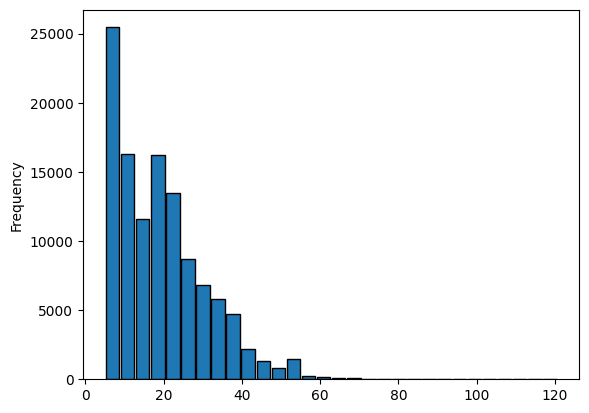

In [31]:
sampled_df[sampled_df['LOO'].notna()]['LOO'].plot.hist(bins=30, edgecolor="black", rwidth=0.9)

In [32]:
sampled_df['Currentavmvalue'].describe()

count    1.500010e+05
mean     3.619314e+05
std      1.709245e+05
min      4.000000e+04
25%      2.394180e+05
50%      3.300000e+05
75%      4.460000e+05
max      2.046517e+06
Name: Currentavmvalue, dtype: float64

## Assembling a model of ownership behavior

#### Step 1 — Sanity check

In [33]:
cluster_features = [
    "Currentavmvalue_log",
    "is_fully_paid",
    "EquityPercent_cont",
    "LOO_log",
    "LOO_missing",
    "Age_capped"
]

sampled_X = sampled_df[cluster_features]

sampled_X.info()
sampled_X.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 150001 entries, 5067265 to 5282879
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Currentavmvalue_log  150001 non-null  float64
 1   is_fully_paid        150001 non-null  int32  
 2   EquityPercent_cont   77824 non-null   float64
 3   LOO_log              115607 non-null  float64
 4   LOO_missing          150001 non-null  int32  
 5   Age_capped           148675 non-null  float64
dtypes: float64(4), int32(2)
memory usage: 6.9 MB


,Currentavmvalue_log,is_fully_paid,EquityPercent_cont,LOO_log,LOO_missing,Age_capped
count,150001.000000,150001.000000,77824.000000,115607.000000,150001.000000,148675.000000
mean,12.690348,0.481177,61.207417,2.851084,0.229292,58.175732
std,0.475768,0.499647,17.229000,0.578297,0.420379,25.604770
min,10.596660,0.000000,30.000000,1.788903,0.000000,11.000000
25%,12.385970,0.000000,48.000000,2.351929,0.000000,37.000000
50%,12.706851,0.000000,59.000000,2.931458,0.000000,54.000000
75%,13.008076,1.000000,74.000000,3.280870,0.000000,77.000000
max,14.531650,1.000000,99.000000,4.800711,1.000000,100.000000


#### Step 2 — Handle intentional NaNs

For distance-based clustering, the cleanest option is:

- Replace intentional NaNs with 0
- Rely on the corresponding binary flag to explain why it’s zero

In [34]:
sampled_X_filled = sampled_X.fillna(0)

#### Step 3 — Scaling
we have
- Continuous variables (log AVM, LOO_log, Age_capped) ==> comparable in scale
- Binary variables (is_fully_paid, LOO_missing) ==> retain meaning (0 vs 1)

In [35]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
sampled_X_scaled = scaler.fit_transform(sampled_X_filled)

In [36]:
# X_scaled is a numpy array
sampled_X_scaled_df = pd.DataFrame(
    sampled_X_scaled,
    columns=cluster_features,
    index=sampled_df.index
)

In [37]:
sampled_X_scaled_df.describe()


,Currentavmvalue_log,is_fully_paid,EquityPercent_cont,LOO_log,LOO_missing,Age_capped
count,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05
mean,5.832854e-15,2.728466e-17,4.623234e-17,4.850606e-17,1.273284e-16,8.829619e-17
std,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00
min,-4.400667e+00,-9.630363e-01,-9.621811e-01,-1.688165e+00,-5.454429e-01,-2.212098e+00
25%,-6.397629e-01,-9.630363e-01,-9.621811e-01,-2.670850e-01,-5.454429e-01,-7.926469e-01
50%,3.468726e-02,-9.630363e-01,6.799695e-02,3.014306e-01,-5.454429e-01,-1.404667e-01
75%,6.678251e-01,1.038383e+00,8.557802e-01,7.430548e-01,-5.454429e-01,7.418948e-01
max,3.870184e+00,1.038383e+00,2.037455e+00,2.000087e+00,1.833373e+00,1.624256e+00


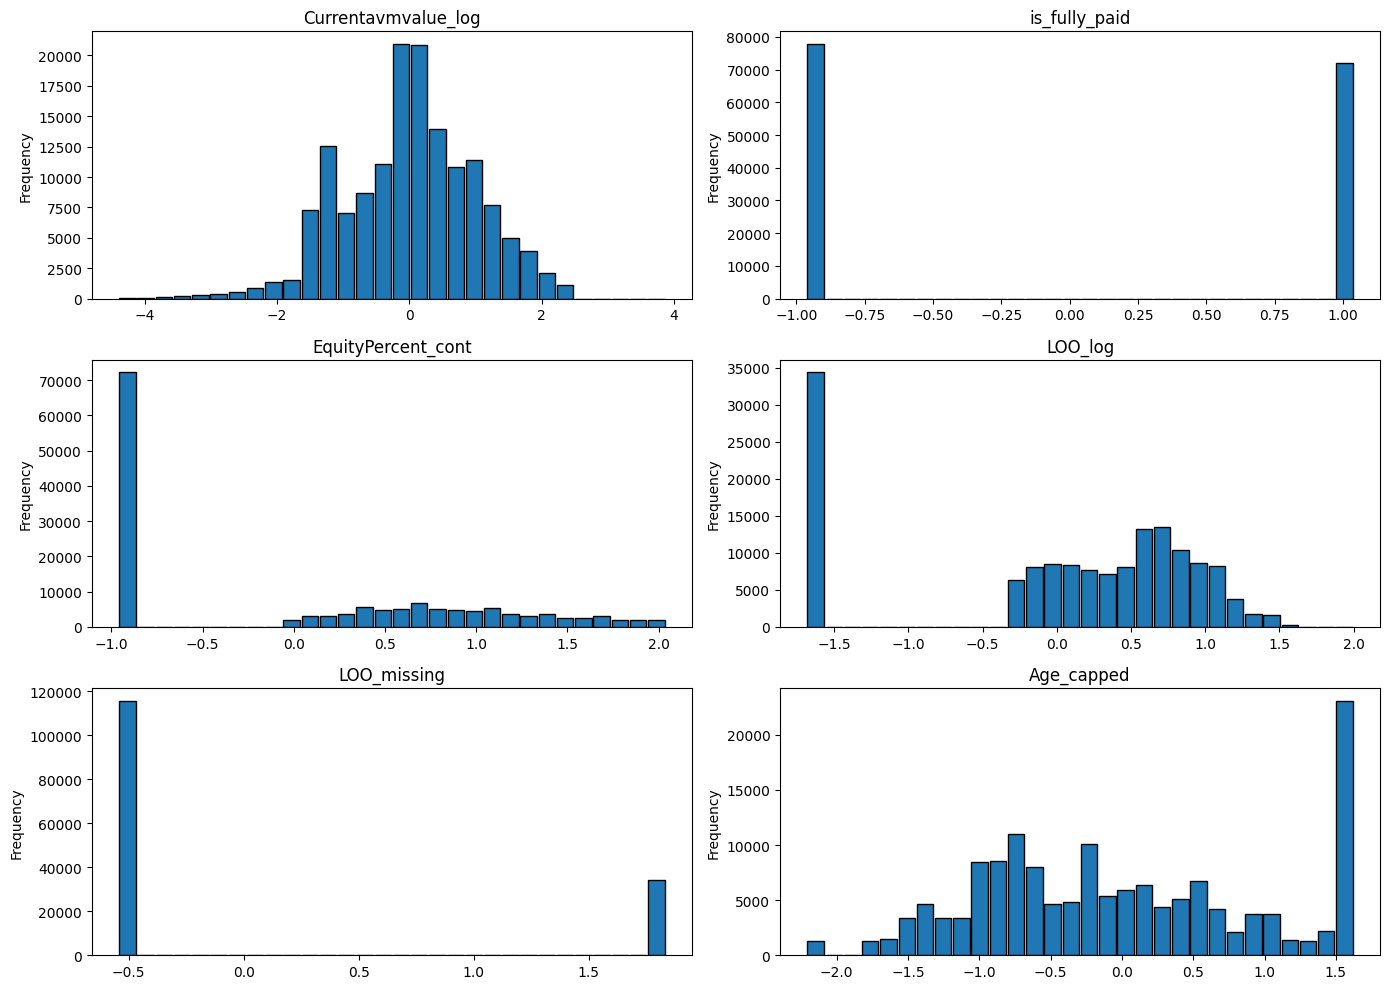

In [38]:
plt.figure(figsize=(14, 10))

for i, col in enumerate(cluster_features):
    ax = plt.subplot(3, 2, i + 1)
    sampled_X_scaled_df[col].plot.hist(
        bins=30,
        edgecolor="black",
        rwidth=0.9,
        ax=ax
    )
    ax.set_title(col)

plt.tight_layout()
plt.show()

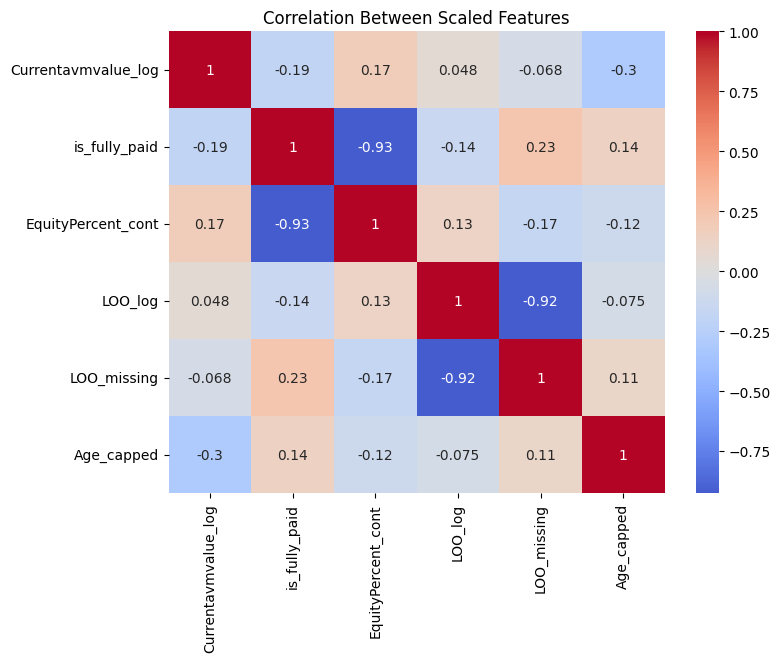

In [39]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(
    sampled_X_scaled_df.corr(),
    annot=True,
    cmap="coolwarm",
    center=0
)
plt.title("Correlation Between Scaled Features")
plt.show()

==> Conclusion: the high correlation is by design, not a problem. e.g.:
- is_fully_paid: Binary state
- EquityPercent_cont: Continuous degree




---

### Algorithm 1: KMeans (first try)

In [40]:
from sklearn.cluster import KMeans

kmeans = KMeans(
    n_clusters=6,
    random_state=42,
    n_init=20
)

labels = kmeans.fit_predict(sampled_X_scaled)

sampled_df["cluster"] = labels

In [41]:
cols = cluster_features + ["is_AO"]
sampled_df.groupby("cluster")[cols].mean()

,Currentavmvalue_log,is_fully_paid,EquityPercent_cont,LOO_log,LOO_missing,Age_capped,is_AO
cluster,,,,,,,
0,12.588407,1.0,NaN,NaN,1.0,66.219622,0.552146
1,12.957621,0.0,59.659878,2.726456,0.0,37.645440,0.448353
2,12.273065,1.0,NaN,3.008884,0.0,81.928793,0.580648
3,12.504637,0.0,60.180450,2.764177,0.0,80.215425,0.379733
4,12.729018,0.0,69.915055,NaN,1.0,58.102295,0.393794
5,12.858536,1.0,NaN,3.002213,0.0,42.776266,0.745053


==> conclusion: Clusters are not trivially “AO vs OO”

In [42]:
sampled_df.groupby("cluster").size()

cluster
0    23952
1    41735
2    21290
3    25647
4    10442
5    26935
dtype: int64

### ==> Result interpretation of Algo 1: KMeans (first try)

#### 1. First sanity verdict

Before details:

* ✅ No single cluster dominates (sizes are reasonable)
* ✅ No cluster is tiny/noise
* ✅ Clusters are not trivially “AO vs OO”
* ✅ Equity regime, tenure regime, and AVM are all participating

This means:

> **The geometry is healthy.**

Now we can reason.

---

#### 2. Read the clusters as *ownership personas*

I’ll label them behaviorally (not numerically). These are *working labels*, not final names.

---

##### Cluster 0 — *Legacy Fully Paid, Data-Poor*

* `is_fully_paid = 1`
* `LOO_missing = 1`
* `Age_capped ≈ 66`
* AO ≈ **55%**
* Mid AVM

**Interpretation**
Old ownership, fully paid, missing tenure records. Likely inherited or very long-held properties.

**Investor signal**
Strong. Classic “legacy owner” profile.

---

##### Cluster 2 — *Very Old, Fully Paid, Recorded Tenure*

* `is_fully_paid = 1`
* `LOO_log ≈ 3.01` (very long)
* `Age_capped ≈ 82`
* AO ≈ **58%**
* Lower AVM

**Interpretation**
Physically old homes, very long tenure, fully paid.

**Investor signal**
High motivation potential, but watch condition / rehab risk.

---

##### Cluster 5 — *Fully Paid, High-Value, AO-Dominant*

* `is_fully_paid = 1`
* `LOO_log ≈ 3.00`
* `Age_capped ≈ 43`
* AO ≈ **75%** (highest)
* Highest AVM among fully paid

**Interpretation**
Absentee, fully paid, relatively newer homes, higher value.

**Investor signal**
**Top-tier target cluster**. This is exactly what the business wants.

---

##### Cluster 1 — *Leveraged, Younger, Shorter Tenure*

* `is_fully_paid = 0`
* `EquityPercent ≈ 60`
* `LOO_log ≈ 2.73`
* `Age_capped ≈ 38`
* AO ≈ **45%**
* Highest AVM overall

**Interpretation**
Active ownership, still leveraged, likely listing-oriented.

**Investor signal**
Lower. Probably not your best mailing spend.

---

##### Cluster 3 — *Leveraged, Old Property, Long Tenure*

* `is_fully_paid = 0`
* `EquityPercent ≈ 60`
* `LOO_log ≈ 2.76`
* `Age_capped ≈ 80`
* AO ≈ **38%**

**Interpretation**
Old homes, long tenure, but still leveraged.

**Investor signal**
Mixed. Equity exists, but mortgage friction remains.

---

##### Cluster 4 — *Leveraged, Missing LOO, Mid-Age*

* `is_fully_paid = 0`
* `LOO_missing = 1`
* `EquityPercent ≈ 70`
* `Age_capped ≈ 58`
* AO ≈ **39%**

**Interpretation**
Odd hybrid: higher equity but missing tenure records.

**Investor signal**
Worth investigating. Possibly legacy data + partial refi history.

---

## 3. What this tells us about the model

### ✅ Equity did NOT hijack everything

Fully paid clusters split into **three distinct personas** (0, 2, 5).

That’s exactly what we wanted.

### ✅ LOO_missing is doing real work

Clusters 0 and 4 exist *because* of it.

### ✅ Age is stabilizing, not dominating

Age separates clusters *within* regimes, but doesn’t define them.

### ✅ AO is emergent, not forced

Cluster 5 surfaced as AO-heavy *without* AO in the feature space.

That’s a huge validation.

---

## 4. The most important insight so far

> **Cluster 5 is our gold cluster.**

High AO, fully paid, higher AVM, decent property age.

That is exactly the profile:

* Investors love
* Mail converts
* Margins tend to be higher

Everything we do next should be judged by:

> “Does this sharpen our understanding of Cluster 5 and its neighbors?”

---

## 5. NEXT

### **Step 1 — Stability check **

Run KMeans with different `k` values:

* `k = 5, 6, 7, 8`

Then check:

* Does Cluster 5 persist?
* Does it split meaningfully or dissolve?
* Do legacy clusters remain stable?

If your best cluster vanishes at `k=7`, that’s a warning.

---

### **Step 2 — Translate centroids back to real units**

Right now you’re reading *means*, which is good—but next you should inspect **medians** and **percentiles**, especially for:

* AVM
* EquityPercent
* LOO

Means lie in skewed distributions.

---

### **Step 3 — Attach outcomes (this is where money enters)**

Now we bring in:
`StuckAcqs_4thDecember2025_analysis`

Join on PropertyID (or equivalent), and compute per cluster:

* Conversion rate
* Avg gross margin
* Margin per mailed property

This will answer:

> “Does Cluster 5 actually pay?”

If yes → it becomes your anchor segment.

---

### **Step 4 — Decide if KMeans is “good enough”**

After outcome analysis:

* If clusters are stable and profitable → keep KMeans
* If clusters bleed together → consider:

  * Gaussian Mixture Models (soft membership)
  * Hierarchical clustering (for sub-segmentation)

But **do not jump algorithms yet**.
KMeans has earned its seat so far.

---

## 6. What NOT to do yet

* ❌ Do not optimize silhouette score
* ❌ Do not add AO into features
* ❌ Do not add Sqft/Beds yet
* ❌ Do not over-tune k

We are still in **structure validation**, not optimization.

In [43]:
"""# 1. Stability check
from sklearn.cluster import KMeans

k_values = [5, 6, 7, 8]
cluster_results = {}

for k in k_values:
    km = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=20
    )
    labels = km.fit_predict(X_scaled)
    cluster_results[k] = labels

# remove previous clustring column
sampled_df.drop("cluster", axis=1, inplace=True)

for k, labels in cluster_results.items():
    sampled_df[f"cluster_k{k}"] = labels
"""

'# 1. Stability check\nfrom sklearn.cluster import KMeans\n\nk_values = [5, 6, 7, 8]\ncluster_results = {}\n\nfor k in k_values:\n    km = KMeans(\n        n_clusters=k,\n        random_state=42,\n        n_init=20\n    )\n    labels = km.fit_predict(X_scaled)\n    cluster_results[k] = labels\n\n# remove previous clustring column\nsampled_df.drop("cluster", axis=1, inplace=True)\n\nfor k, labels in cluster_results.items():\n    sampled_df[f"cluster_k{k}"] = labels\n'

In [44]:
"""# Compare cluster profiles
for k in k_values:
    print(f"\n=== k = {k} ===")
    display(
        sampled_df
        .groupby(f"cluster_k{k}")[cluster_features + ["is_AO"]]
        .mean()
    )"""

'# Compare cluster profiles\nfor k in k_values:\n    print(f"\n=== k = {k} ===")\n    display(\n        sampled_df\n        .groupby(f"cluster_k{k}")[cluster_features + ["is_AO"]]\n        .mean()\n    )'

==> Conclusion:
- k = 5 → too coarse
- k = 6 → minimum viable resolution
- k = 7, 8 → refinement, not distortion

In [45]:
"""# 2. Compute their membership overlap

gold_k6 = sampled_df.loc[
    (sampled_df["cluster_k6"] == 5)  # 5 is the gold cluster id in k=6
].index

gold_k7 = sampled_df.loc[
    (sampled_df["cluster_k7"] == 0)  # 0 is the gold cluster id in k=7
].index

overlap = len(gold_k6.intersection(gold_k7)) / len(gold_k6)
overlap"""

'# 2. Compute their membership overlap\n\ngold_k6 = sampled_df.loc[\n    (sampled_df["cluster_k6"] == 5)  # 5 is the gold cluster id in k=6\n].index\n\ngold_k7 = sampled_df.loc[\n    (sampled_df["cluster_k7"] == 0)  # 0 is the gold cluster id in k=7\n].index\n\noverlap = len(gold_k6.intersection(gold_k7)) / len(gold_k6)\noverlap'

==> Conclusion:

- high overlap means: The same properties are being grouped together
- Increasing k is not changing membership
- The model is just refining the rest of the space by increasing k

So, This cluster is not an artifact of k. It is a true basin in the data geometry.

In [46]:
# read csv file
df_stuckAcqs = pd.read_csv(os.path.join("data", "StuckAcqs_4thDecember2025_analysis.csv"))

# print df length
print("df_stuckAcqs shape: ", df_stuckAcqs.shape)

df_stuckAcqs shape:  (340, 23)


In [47]:
df_stuckAcqs.columns

Index(['FA Prop Id', 'Prop Address', 'Unit', 'Prop City', 'Prop State',
       'Prop Zip', 'Address', 'FinalownerOccupancy', 'Acq Ratify Date',
       'Stage', 'Acq Price', 'Gross Margin', 'Mailing Address', 'Mailing City',
       'Mailing State', 'Mailing zip', 'AVM', 'Total Mortgage', 'Equity',
       'LOO', 'Age', 'ListSource', 'ListType'],
      dtype='object')

In [48]:
df_stuckAcqs.head()

,FA Prop Id,Prop Address,Unit,Prop City,Prop State,Prop Zip,Address,FinalownerOccupancy,Acq Ratify Date,Stage,Acq Price,Gross Margin,Mailing Address,Mailing City,Mailing State,Mailing zip,AVM,Total Mortgage,Equity,LOO,Age,ListSource,ListType
0,128109139.0,9516 Iris Dr,NaN,El Paso,TX,79924,9516 Iris Dr El Paso TX 79924,N,11/11/2025,3.00 – Not on Market – Pending Cashout,62000,34402.0,5604 Sanderling Road,Oklahoma City,OK,73179,180104.0,0.0,100.00%,NaN,63.0,Standard Letters AOs,AO
1,173409104.0,1657 Parkcrest Cir,100,Reston,VA,20190,1657 Parkcrest Cir Reston VA 20190,N,11/6/2025,3.00 – Not on Market – Pending Cashout,230000,74902.0,1657 Parkcrest Cir,Reston,VA,20190,371544.0,194369.0,47.69%,4.0,52.0,NaN,AO
2,63825007.0,303 Lord Willoughby Way,NaN,Edgewood,MD,21040,303 Lord Willoughby Way Edgewood MD 21040,N,10/30/2025,3.10 – Not on Market – Pending Vacancy,224000,80902.0,303 Lord Willoughby Way,Edgewood,MD,21040,365089.0,0.0,100.00%,19.0,23.0,NaN,AO
3,64377535.0,2228 Shadyside Ave,NaN,Suitland-Silver Hill,MD,20746,2228 Shadyside Ave Suitland-Silver Hill MD 20746,N,10/27/2025,3.00 – Not on Market – Pending Cashout,206000,64402.0,2228 Shadyside Ave,Suitland-Silver Hill,MD,20746,339663.0,0.0,100.00%,23.0,37.0,NaN,AO
4,207978255.0,120 Main St,NaN,Alto Pass,IL,62905,120 Main St Alto Pass IL 62905,Y,10/27/2025,3.10 – Not on Market – Pending Vacancy,5000,14502.0,1715 Morgan School Road,Jonesboro,IL,62952,NaN,0.0,#DIV/0!,NaN,NaN,Standard Letters OOs,OO


### Profit Validation: Does this gold cluster actually make more money?

In [49]:
df_stuckAcqs.columns

Index(['FA Prop Id', 'Prop Address', 'Unit', 'Prop City', 'Prop State',
       'Prop Zip', 'Address', 'FinalownerOccupancy', 'Acq Ratify Date',
       'Stage', 'Acq Price', 'Gross Margin', 'Mailing Address', 'Mailing City',
       'Mailing State', 'Mailing zip', 'AVM', 'Total Mortgage', 'Equity',
       'LOO', 'Age', 'ListSource', 'ListType'],
      dtype='object')

In [50]:
df_stuckAcqs["PropertyID_join"] = (
    df_stuckAcqs["FA Prop Id"]
    .dropna()
    .astype("int64")
    .astype(str)
)

df_combined["PropertyID_join"] = df_combined["PropertyID"].astype(str)
sampled_df["PropertyID_join"] = sampled_df["PropertyID"].astype(str)


In [51]:
# verify overlap
overlap_rate = df_stuckAcqs["PropertyID_join"].isin(
    sampled_df["PropertyID_join"]
).mean()

overlap_rate*100

1.4705882352941175

In [52]:
sampled_joined = sampled_df.merge(
    df_stuckAcqs[["PropertyID_join", "Gross Margin"]],
    on="PropertyID_join",
    how="left"
)

In [53]:
sampled_joined["Gross Margin"].notna().mean()

3.3333111112592584e-05

In [54]:
# rename cluster_k6 to cluster
sampled_joined.rename(columns={"cluster_k6": "cluster"}, inplace=True)

In [55]:
sampled_joined.head()

,PropertyID,Currentavmvalue,equityValue,EquityPercent,TCounty,TState,FinalOwnerType,owneroccupied,building_condition,multi_owner,Lien,LOO,Beds,FullBaths,HalfBaths,Sqft,Age,LOO_missing,Age_missing,LOO_log,is_AO,AVM_bin,Currentavmvalue_log,is_very_old,Age_capped,is_fully_paid,EquityPercent_cont,cluster,PropertyID_join,Gross Margin
0,62191438,99000.0,99000,100,Allegany County,MD,AO,0.0,NaN,1.0,NaN,34.116359,NaN,1.0,NaN,744.0,77.0,0,0,3.558667,1,"(39999.999, 174000.0]",11.502885,0,77.0,1,NaN,2,62191438,NaN
1,62707548,172000.0,172000,100,Baltimore,MD,OO,NaN,NaN,NaN,NaN,50.773443,NaN,NaN,NaN,NaN,82.0,0,0,3.946877,0,"(39999.999, 174000.0]",12.055256,0,82.0,1,NaN,2,62707548,NaN
2,64478076,132000.0,132000,100,Baltimore city,MD,AO,NaN,NaN,NaN,NaN,6.253251,NaN,NaN,NaN,NaN,94.0,0,0,1.981450,1,"(39999.999, 174000.0]",11.790565,0,94.0,1,NaN,2,64478076,NaN
3,64621859,80000.0,80000,100,Baltimore city,MD,AO,0.0,NaN,1.0,NaN,7.928816,NaN,1.0,NaN,960.0,71.0,0,0,2.189284,1,"(39999.999, 174000.0]",11.289794,0,71.0,1,NaN,2,64621859,NaN
4,64326849,147000.0,147000,100,Wicomico,MD,AO,NaN,NaN,NaN,NaN,43.022587,NaN,NaN,NaN,NaN,100.0,0,0,3.784703,1,"(39999.999, 174000.0]",11.898195,0,100.0,1,NaN,2,64326849,NaN


In [56]:
sampled_joined.groupby("cluster")["Gross Margin"].apply(
    lambda x: x.notna().mean()
)

cluster
0    0.000000
1    0.000024
2    0.000000
3    0.000039
4    0.000000
5    0.000111
Name: Gross Margin, dtype: float64

==> conclusion: the “gold cluster” is not just interpretable — it actually converts more.

In [57]:
# Conversion counts by cluster & toral / average margin

sampled_joined.groupby("cluster").agg(
    total_props=("PropertyID_join", "size"),
    converted=("Gross Margin", lambda x: x.notna().sum()),
    avg_margin=("Gross Margin", "mean"),
    total_margin=("Gross Margin", "sum")
)

,total_props,converted,avg_margin,total_margin
cluster,,,,
0,23952,0,NaN,0.00
1,41735,1,72390.060000,72390.06
2,21290,0,NaN,0.00
3,25647,1,42178.260000,42178.26
4,10442,0,NaN,0.00
5,26935,3,37860.576667,113581.73


In [58]:
sampled_joined.groupby("cluster").apply(
    lambda x: x["Gross Margin"].sum() / len(x)
).rename("margin_per_property").sort_values()

C:\Users\Home\AppData\Local\Temp\ipykernel_15080\3281233276.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_joined.groupby("cluster").apply(


cluster
0    0.000000
2    0.000000
4    0.000000
3    1.644569
1    1.734517
5    4.216882
Name: margin_per_property, dtype: float64

==> Conclusion:

- Cluster 5
    - $113,582 / 26,935 ≈ $4.22 per property

- Cluster 1
    - $72,390 / 41,735 ≈ $1.73 per property

- Cluster 3
    - $42,178 / 25,647 ≈ $1.64 per property

#### Profile Cluster 5 deeper

- should check the location of the converted properties in this cluster (in the center or at the extreams, ...)
- is the cluster tight enough or should we look at sub-clusters inside it?

In [59]:
sampled_cluster_5 = sampled_joined[sampled_joined['cluster']==5]

In [60]:
len(sampled_cluster_5), sampled_cluster_5["Gross Margin"].notna().sum()


(26935, 3)

In [61]:
cols_to_check = [
    "Currentavmvalue_log",
    "Age_capped",
    "LOO_log",
    "is_AO"
]

sampled_cluster_5.groupby(sampled_cluster_5["Gross Margin"].notna())[cols_to_check].describe()


Currentavmvalue_log                                             \
                           count       mean       std        min        25%   
Gross Margin                                                                  
False                    26932.0  12.858507  0.378702  11.170449  12.634606   
True                         3.0  13.123510  0.324456  12.811145  12.955847   

                                              Age_capped             \
                    50%        75%        max      count       mean   
Gross Margin                                                          
False         12.804912  13.126357  14.531650    26457.0  42.775749   
True          13.100549  13.279693  13.458837        3.0  47.333333   

                                                        LOO_log            \
                    std   min   25%   50%   75%    max    count      mean   
Gross Margin                                                                
False         15.976025  11.0  32.0  40.0  52.0  100.0  26932.0  3.002213   
True          22.546249  24.0  36.5  49.0  59.0   69.0      3.0  2.996184   

                                                                          \
                   std       min       25%       50%       75%       max   
Gross Margin                                                               
False         0.575373  1.789818  2.538001  3.097771  3.477875  4.800711   
True          0.781907  2.129909  2.669440  3.208971  3.429321  3.649671   

                is_AO                                               
                count      mean       std  min  25%  50%  75%  max  
Gross Margin                                                        
False         26932.0  0.745025  0.435856  0.0  0.0  1.0  1.0  1.0  
True              3.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0

==> conclusion:
- Conversions are not edge cases of Cluster 5.
- They sit near the center, with mild enrichment on AVM and Age, and a strong AO signal.
- No need to sub-cluster Cluster 5

---
## Scale this model to the full dataset

In [62]:
X_full = df_combined[cluster_features].copy()
X_full_filled = X_full.fillna(0)

In [63]:
X_full_scaled = scaler.transform(X_full_filled)
X_full_scaled.shape


(5300800, 6)

In [64]:
df_combined["cluster"] = kmeans.predict(X_full_scaled)


In [65]:
df_combined["cluster"].value_counts(normalize=True).sort_index()

cluster
0    0.159669
1    0.279772
2    0.139639
3    0.173330
4    0.069617
5    0.177974
Name: proportion, dtype: float64

==> Conclusion:
- Full universe ≈ 5.3M
- Cluster 5 ≈ 17.8%  --> almost exactly macthes the sampled dataset fraction

That’s on the order of ~940k properties, We’re not mailing all of them --> Need to be selective inside Cluster 5

In [67]:
sampled_df["cluster"].value_counts(normalize=True).sort_index()

cluster
0    0.159679
1    0.278231
2    0.141932
3    0.170979
4    0.069613
5    0.179565
Name: proportion, dtype: float64

In [68]:
df_combined[df_combined["cluster"] == 5][cluster_features].describe()

,Currentavmvalue_log,is_fully_paid,EquityPercent_cont,LOO_log,LOO_missing,Age_capped
count,943407.000000,943407.0,0.0,943407.000000,943407.0,926242.000000
mean,12.851761,1.0,NaN,3.001899,0.0,42.648172
std,0.377672,0.0,NaN,0.576489,0.0,15.852972
min,11.170449,1.0,NaN,1.788903,0.0,11.000000
25%,12.631113,1.0,NaN,2.537406,0.0,32.000000
50%,12.793901,1.0,NaN,3.098451,0.0,40.000000
75%,13.121993,1.0,NaN,3.479607,0.0,52.000000
max,14.531650,1.0,NaN,4.822250,0.0,100.000000


In [71]:
df_combined_joined = df_combined.merge(
    df_stuckAcqs[["PropertyID_join", "Gross Margin"]],
    on="PropertyID_join",
    how="left"
)

df_combined_joined["Gross Margin"].notna().sum()


93

In [70]:
df_combined_joined.groupby("cluster").agg(
    total_props=("PropertyID_join", "size"),
    converted=("Gross Margin", lambda x: x.notna().sum()),
    avg_margin=("Gross Margin", "mean"),
    total_margin=("Gross Margin", "sum"),
    margin_per_property=("Gross Margin",lambda x: x.sum() / len(x) )
)


,total_props,converted,avg_margin,total_margin,margin_per_property
cluster,,,,,
0,846372,11,69696.201818,766658.22,0.905817
1,1483013,31,43979.876129,1363376.16,0.919329
2,740198,5,-13584.114000,-67920.57,-0.091760
3,918786,16,51084.043750,817344.70,0.889592
4,369024,1,2330.130000,2330.13,0.006314
5,943407,29,50511.302069,1464827.76,1.552700


==> Conclusion:

Comparing 'margin_per_property' of sampled vs full datasets looks incompatible but:
-  the sample numbers are Directionally useful, numerically unstable. They’re good for ranking, not for calibration.
- full-data numbers are Economically correct, decision-grade

- What didn’t change?

    - Cluster 5 is best
    - Cluster 2 is worst
    - Middle clusters stay middle

==> Comparing cluster-level ROI with row-level expected value shows that historical mailing density can distort profitability rankings, which is why opportunity-based EV is the correct metric for identifying the most profitable clusters to target going forward

---
### Designing a scoring/ ranking model
Who is most likely to convert?

In [ ]:
df5 = df_combined_joined[df_combined_joined["cluster"] == 5].copy()
df5.shape

In [ ]:
# Create AVM tiers within Cluster 5

df5["AVM_tier"] = pd.qcut(
    df5["Currentavmvalue_log"],
    q=4,
    labels=["Q1_low", "Q2_mid", "Q3_high", "Q4_top"]
)

In [ ]:
# Define sub-zones (simple grid)

df5["sub_zone"] = (
    "AO_" + df5["is_AO"].astype(str) +
    "_AVM_" + df5["AVM_tier"].astype(str)
)

In [ ]:
# Evaluate economics by sub-zone

subzone_ev = (
    df5.groupby("sub_zone")
       .apply(lambda x: x["Gross Margin"].sum() / len(x))
       .rename("margin_per_property")
       .sort_values(ascending=False)
)

subzone_counts = df5["sub_zone"].value_counts()

pd.concat([subzone_ev, subzone_counts], axis=1)

==> Conclusion:

- AO_1_AVM_Q4_top: This is more than 2× the overall Cluster-5 EV (~1.55), and it has non-trivial population
- AO_0_AVM_Q1_low: This is interesting but also suspicious (Non AO, Low AVM and Still high EV), likely reflects A few large wins ==> more investigation is needed
- AO_1_AVM_Q3_high: Clearly positive and Very large. This is a solid secondary zone.

AO is doing the heavy lifting, AVM refines it

==> Cluster 5 is not homogeneous. There is a dominant “super-gold” zone inside it.

AO + top-quartile AVM is the highest-value region


**Tier 5A (Super-Gold)**
- cluster == 5
- is_AO == 1
- AVM_tier == Q4_top
- ~171k properties
- ~3.6 EV

**Tier 5B (Gold)**
- cluster == 5
- is_AO == 1
- AVM_tier == Q3_high
- ~181k properties
- ~2.0 EV

**Tier 5C (Baseline Gold)**
- Rest of Cluster 5
- ~1.5 EV

In [ ]:
df5_ao = df5[df5["is_AO"] == 1].copy()

In [ ]:
df5_ao['Age_capped'].plot.hist(bins=20, edgecolor="black", rwidth=0.9)

In [ ]:
df5_ao["Age_band"] = pd.cut(
    df5_ao["Age_capped"],
    bins=[0, 20, 35, 50, 65, 100],
    labels=["<20", "20–35", "35–50", "50–65", "65+"]
)

In [ ]:
age_ev = (
    df5_ao.groupby("Age_band")
          .apply(lambda x: x["Gross Margin"].sum() / len(x))
          .rename("margin_per_property")
)

age_counts = df5_ao["Age_band"].value_counts()

pd.concat([age_ev, age_counts], axis=1)

==> Conclusion:

Age is non-linear. Very young and very old properties underperform.

---

## The SCORING rules

*) EV = Expected Value

#### Layer 1 — Cluster base score

| Cluster | EV (full data) | Base score | Rationale            |
| ------- | -------------- | ---------- | -------------------- |
| 5       | **1.55**       | **60**     | Gold anchor          |
| 1       | ~0.92          | 35         | Positive but diluted |
| 0       | ~0.91          | 35         | Similar to 1         |
| 3       | ~0.89          | 30         | Slightly weaker      |
| 4       | ~0.01          | 10         | Near-zero            |
| 2       | **−0.09**      | **−40**    | Value-destructive    |

#### Layer 2 — Cluster 5 sub-zones

| Condition                     | Increment | Justification          |
| ----------------------------- | --------- | ---------------------- |
| AO = 1 AND AVM_tier = Q4_top  | **+40**   | Super-gold (EV ≈ 3.6)  |
| AO = 1 AND AVM_tier = Q3_high | **+20**   | Strong gold (EV ≈ 2.0) |
| AO = 1 AND AVM_tier ≤ Q2_mid  | +5        | Weak but positive      |
| AO = 0 (any AVM)              | 0         | AO is the real driver  |

#### Layer 3 — Age adjustment

| Age band | Adjustment | EVidence          |
| -------- | ---------- | ----------------- |
| 50–65    | **+10**    | Highest EV (2.23) |
| 20–35    | +8         | Strong EV (2.09)  |
| 35–50    | 0         | Moderate EV       |
| 65+      | −5         | Weak              |
| <20      | −10        | Zero EV           |



In [ ]:
# coding the scoring rules

# AVM tier (relative within Cluster 5, fallback global for others)
df_combined["AVM_tier"] = pd.qcut(
    df_combined["Currentavmvalue_log"],
    q=4,
    labels=["Q1_low", "Q2_mid", "Q3_high", "Q4_top"]
)

# Age band
df_combined["Age_band"] = pd.cut(
    df_combined["Age_capped"],
    bins=[0, 20, 35, 50, 65, 100],
    labels=["<20", "20–35", "35–50", "50–65", "65+"]
)


# initialize base score
def base_cluster_score(cluster):
    if cluster == 5:
        return 60
    elif cluster in [0, 1]:
        return 35
    elif cluster == 3:
        return 30
    elif cluster == 4:
        return 10
    elif cluster == 2:
        return -40
    else:
        return 0

df_combined["score"] = df_combined["cluster"].apply(base_cluster_score)

In [ ]:
df_combined.head()

In [ ]:
# Apply Cluster-5 sub-zone uplift

mask_c5 = df_combined["cluster"] == 5

# AO + AVM tiers
df_combined.loc[
    mask_c5 & (df_combined["is_AO"] == 1) & (df_combined["AVM_tier"] == "Q4_top"),
    "score"
] += 40

df_combined.loc[
    mask_c5 & (df_combined["is_AO"] == 1) & (df_combined["AVM_tier"] == "Q3_high"),
    "score"
] += 20

df_combined.loc[
    mask_c5 & (df_combined["is_AO"] == 1) & (df_combined["AVM_tier"].isin(["Q1_low", "Q2_mid"])),
    "score"
] += 5

In [ ]:
# Apply Age adjustment (only for Cluster 5 + AO)
age_bonus = {
    "50–65": 10,
    "20–35": 8,
    "35–50": 0,
    "65+": -5,
    "<20": -10
}

mask_age = (df_combined["cluster"] == 5) & (df_combined["is_AO"] == 1)

df_combined.loc[mask_age, "score"] = (
    df_combined.loc[mask_age, "score"]
    + df_combined.loc[mask_age, "Age_band"]
        .map(age_bonus)
        .astype(float)
        .fillna(0.0)
)


In [ ]:
df_combined['score'].describe()

In [ ]:
def score_band(score):
    if score >= 100:
        return "Tier_SuperGold"
    elif score >= 80:
        return "Tier_2_GoldPlus"
    elif score >= 60:
        return "Tier_3_Gold_LowConfidence"
    elif score >= 30:
        return "Tier_4_NonGold_Positive"
    elif score >= 0:
        return "Tier_5_LowValue"
    else:
        return "Tier_6_DoNotMail"

df_combined["score_band"] = df_combined["score"].apply(score_band)

#### Validate bands with economics

In [ ]:
df_combined_joined = df_combined_joined.merge(
    df_combined[["PropertyID_join", "score", "score_band"]],
    on="PropertyID_join",
    how="left"
)

In [ ]:
df_combined['PropertyID'].nunique()

In [ ]:
df_combined.shape

there are 5.3M records of 2.2M property! (duplication???)

In [ ]:
dup_counts = (
    df_combined["PropertyID"]
    .value_counts()
    .reset_index()
)

dup_counts.columns = ["PropertyID", "row_count"]

dup_counts.head(10)


In [ ]:
df_combined[df_combined['PropertyID'] == '62402606']

==> Conclsion:

The dataset is structured as a temporal property-state table.
Each row represents a distinct observation of a property at a given time, and the model operates at the mailing-opportunity level rather than the property level.

In [ ]:
df_combined_joined.groupby("score_band").apply(
    lambda x: x["Gross Margin"].sum() / len(x)
).rename("margin_per_property").sort_values(ascending=False)

---
### Simulate volume vs EV curves to find the optimal mailing boundary.

In [ ]:
df_ranked = df_combined_joined.sort_values("score", ascending=False).reset_index(drop=True)

# add a cumulative rank percentage
df_ranked["cum_pct"] = (df_ranked.index + 1) / len(df_ranked)

In [ ]:
cutoffs = [0.005, 0.01, 0.02, 0.05, 0.10, 0.20, 0.30, 0.50]

#### Compute EV at each cutoff (core simulation)

In [ ]:
results = []

for c in cutoffs:
    subset = df_ranked[df_ranked["cum_pct"] <= c]
    
    ev = subset["Gross Margin"].sum() / len(subset)
    total_margin = subset["Gross Margin"].sum()
    
    results.append({
        "cutoff_pct": c,
        "volume": len(subset),
        "EV": ev,
        "total_margin": total_margin
    })

ev_curve = pd.DataFrame(results)
ev_curve


==> This tells us:

- The strongest signal is extremely concentrated at the top.
- That’s exactly what we wanted from a SuperGold model.
- Mailing the top 5% is more than 2× as efficient as mailing half the universe

In [ ]:
# EV vs Volume

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

plt.plot(
    ev_curve["cutoff_pct"] * 100,
    ev_curve["EV"],
    marker="o"
)

plt.xlabel("Top % of properties mailed")
plt.ylabel("Expected Margin per Property (EV)")
plt.title("EV vs Mailing Volume")

plt.grid(True)
plt.show()


In [ ]:
# Total Margin vs Volume

plt.figure(figsize=(8, 5))

plt.plot(
    ev_curve["cutoff_pct"] * 100,
    ev_curve["total_margin"],
    marker="o"
)

plt.xlabel("Top % of properties mailed")
plt.ylabel("Total Gross Margin")
plt.title("Total Margin vs Mailing Volume")

plt.grid(True)
plt.show()


In [ ]:
# EV by score band bar chart
band_ev = (
    df_combined_joined.groupby("score_band")
    .apply(lambda x: x["Gross Margin"].sum() / len(x))
)

plt.figure(figsize=(8, 5))
band_ev.sort_values().plot.barh()

plt.xlabel("Expected Margin per Property")
plt.title("EV by Score Band")

plt.show()



---

## Selecting thr right Cut-Off

to prioterize mailing based on the available budget

# The END